# Clustering
In this notebook we'll walk through the steps to set up a nearest neighbor network and a few different clustering algorithms. 

--------

We're going to directly import our pre-processed Giotto object that we've demonstrated in previous notebooks. The code for this import is in this [script](https://github.com/ndelrossi7/r-conda-binder/blob/main/scripts/preprocess.R).


(_Note: It will generate a plot for highly variable genes. You can either disregard this or run additional plots based on some examples from this [notebook](https://github.com/ndelrossi7/r-conda-binder/blob/main/notebooks/3-Dimensionality-Reduction.ipynb)_

Skipping install of 'Giotto' from a github remote, the SHA1 (1b60529f) has not changed since last install.
  Use `force = TRUE` to force installation




 giotto environment found at 
 /Users/Natalie_1/Library/r-miniconda/envs/giotto_env/bin/pythonw 
Giotto environment is already installed, set force_environment = TRUE to reinstall 
Consider to install these (optional) packages to run all possible Giotto commands:  MAST tiff biomaRt trendsceek multinet RTriangle FactoMiner
 Giotto does not automatically install all these packages as they are not absolutely required and this reduces the number of dependencies
 no external python path was provided, but a giotto python environment was found and will be used 

 first scale genes and then cells 
return_plot = TRUE and return_gobject = TRUE 

          plot will not be returned to object, but can still be saved with save_plot = TRUE or manually 
hvg  was found in the gene metadata information and will be used to select highly variable genes 


Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”


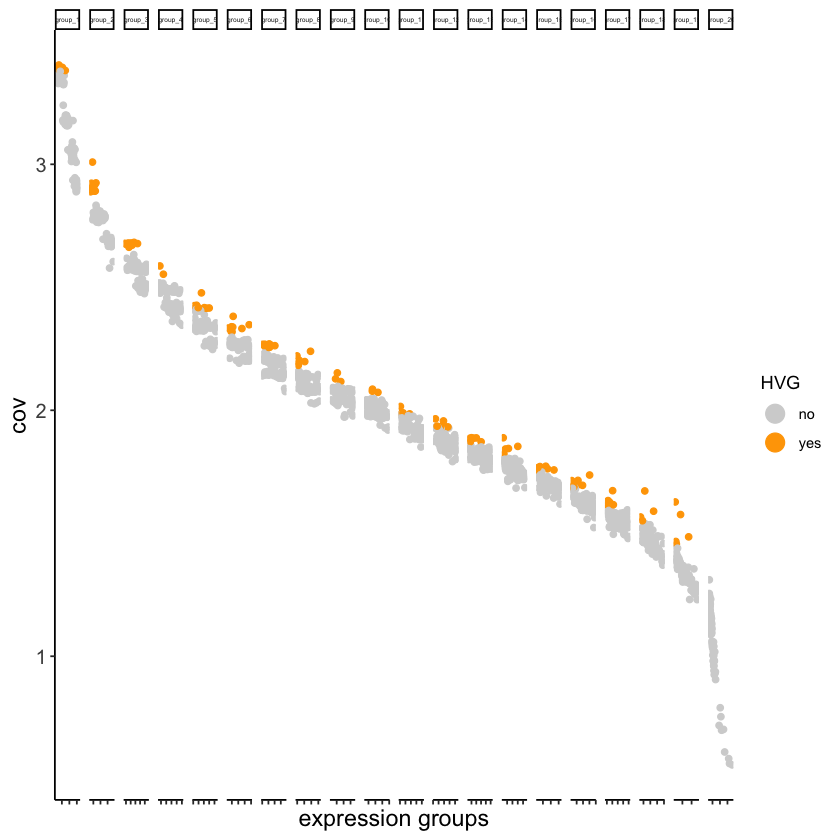

In [2]:
# you may have to run this cell twice if you get an error first
setwd(dirname(getwd()))
source("r-conda-binder/scripts/preprocess.R")

### 1. Nearest neighbor network
To start, we'll generate a [nearest neighbor network](https://rubd.github.io/Giotto_site/reference/createNearestNetwork.html).
We'll create a shared nearest neighbor (sNN) network in this example, but you can also use a k-nearest neighbor (kNN) network. This will be based on your provided dimension reduction space. You can also run this without any dimensionality reduction. 

In [3]:
my_giotto_object <- createNearestNetwork(
  my_giotto_object,
  type = "sNN", 
  dim_reduction_to_use = "pca",
  dim_reduction_name = "pca",
  dimensions_to_use = 1:10,
  genes_to_use = NULL,
  expression_values = c("normalized", "scaled", "custom"),
  name = "sNN.pca",
  return_gobject = TRUE,
  k = 30,
  minimum_shared = 5,
  top_shared = 3,
  verbose = T,
)

## We can now begin some clustering:

### 2. Leiden clustering

Below we will use the [Leiden](https://rubd.github.io/Giotto_site/reference/doLeidenCluster.html) community detection algorithm.

named list()

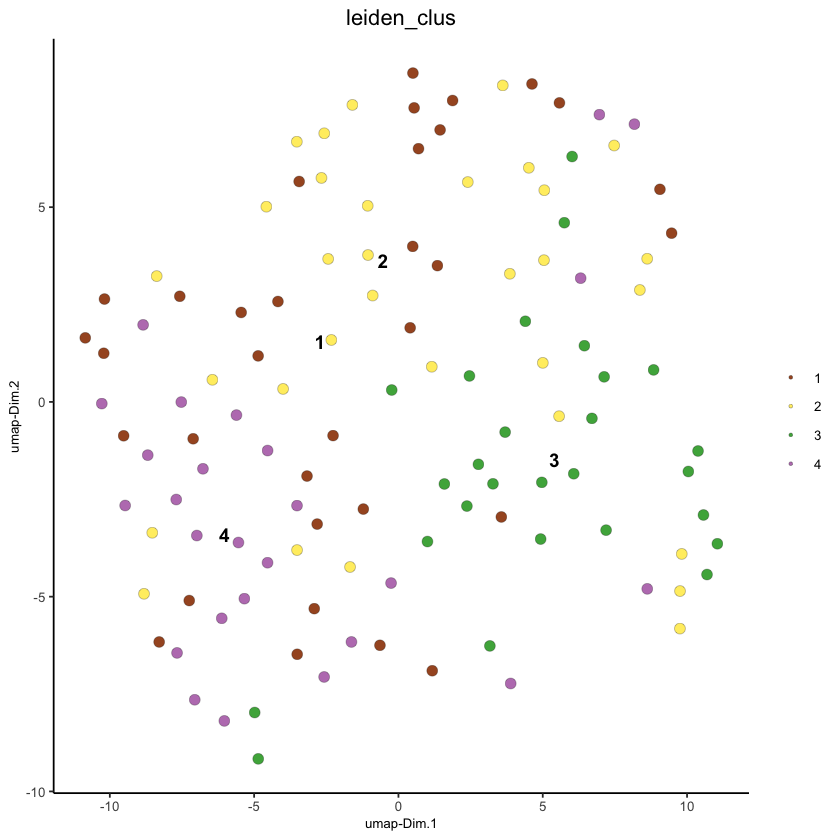

In [4]:
# run Leiden cluster
my_giotto_object <- doLeidenCluster(
  my_giotto_object, 
  name = 'leiden_clus')

# Plot results
plotUMAP_2D(my_giotto_object, cell_color = 'leiden_clus', point_size = 3)[0]